In [1]:
# import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
import csv
import shapely as sp
import pickle
import matplotlib.pyplot as plt

import numpy as np

from matplotlib import rc
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

mpl.rcParams["axes.formatter.use_mathtext"] = True

In [2]:
# Carga el polígono de la ciudad de méxico, aplica un buffer de 100 mts y lo proyecta a WGS84
cdmx = gpd.read_file(r'../GeoData/Polygons.gpkg', layer='CDMX', encoding='utf-8')
polygon = cdmx.geometry[0].buffer(100)
cdmx['geometry'] = polygon
# cdmx.to_crs(4326, inplace=True)
polygon = cdmx.geometry[0]
(lon1 , lat1, lon2, lat2) = polygon.bounds
alcaldias = gpd.read_file(r'../GeoData/Polygons.gpkg', layer='alcaldias', encoding='utf-8')

In [3]:
# Nombre del escenario a partir del cual se obtendrá el KDE
escenario = '2017_daños'

# Carga el archivo con la ubicación de los puntos de atención
colapsos = gpd.read_file(r'../GeoData/Points.gpkg', layer = escenario)
# colapsos.to_crs(4326, inplace=True)
# Obtiene las coordenadas
colapsos_coords = colapsos.get_coordinates()

In [4]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KernelDensity

# Obtiene las coordenadas de los puntos dañados
x = colapsos['geometry'].centroid.x
y = colapsos['geometry'].centroid.y

# Crea un arreglo con las coordenadas
Xtrain = np.vstack([x, y]).T 


In [5]:
# Calcula el mejor ancho de banda para el kernel
# usa el método de validación cruzada para encontrar el mejor ancho de banda
bandwidths = 10 ** np.linspace(1, 4, 1000)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(Xtrain);

bw_best = grid.best_params_['bandwidth']

print('El mejor ancho de banda es: ')
print(bw_best)

El mejor ancho de banda es: 
1365.0078065460139


In [6]:
# Determina el área de representación
min_x, min_y, max_x, max_y = (lon1, lat1, lon2, lat2)

# Crea una malla de 500 x 500 celdas
XX, YY = np.mgrid[min_x:max_x:500j, min_y:max_y:500j]

# Crea un arreglo con las coordenadas de la malla en pares
mesh_pairs = np.vstack([XX.ravel(), YY.ravel()]).T

# Genera el modelo de densidad de kernel con el mejor ancho de banda y el kernel gaussiano
kde = KernelDensity(bandwidth = 1365, metric = 'euclidean', kernel = 'gaussian', algorithm = 'auto')

# Ajusta el modelo a los datos
kde.fit(Xtrain)

# Evalua el modelo en la malla
Z = np.exp(kde.score_samples(mesh_pairs))

# Normaliza los datos de la malla
Z /= Z.sum()

# Reshape para graficar
Z = Z.reshape(XX.shape)

# plot contours of the density
levels = np.linspace(0, Z.max(), 50)

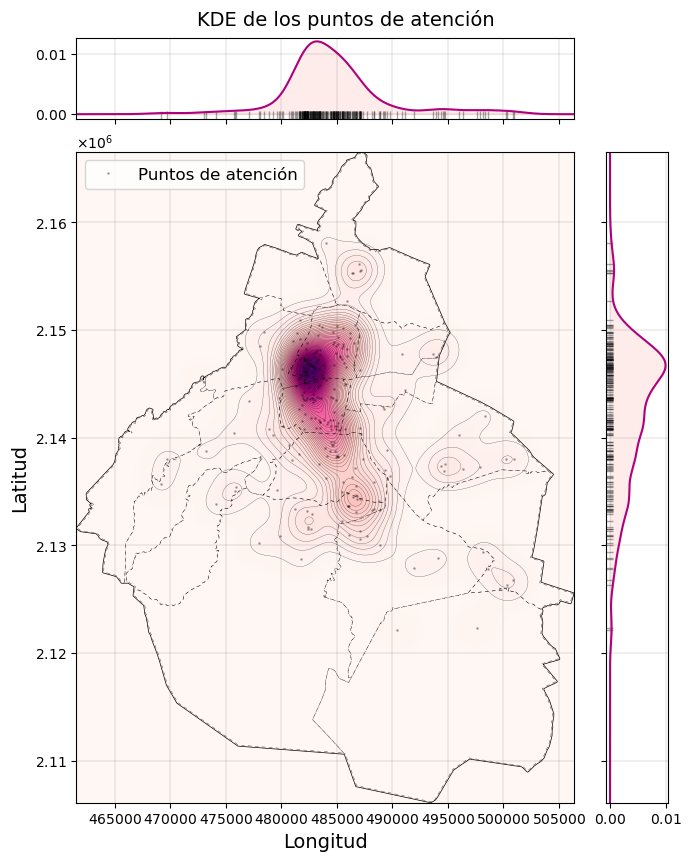

In [7]:
from matplotlib import cm as cm
cmap = cm.RdPu

fig,axs = plt.subplots(2,2,sharex='col', sharey='row', width_ratios=[0.8,0.1], height_ratios=[0.1,0.8], 
                       figsize=(4*1.7,5*1.7), constrained_layout=True)
axs[0, 1].remove()

sum_x = np.sum(Z, axis = 1)
sum_y = np.sum(Z, axis = 0)

Zr = np.rot90(Z)



fig.suptitle('KDE de los puntos de atención', fontsize = 14)

# Grafica la distribución de los puntos de atención en el eje x
axs[0,0].plot(x, np.full_like(x, -np.max(Z)), '|k', markeredgewidth=1, alpha=0.35)
axs[0,0].plot(XX[:,0], sum_x, c = cmap(0.75))
axs[0,0].fill_between(XX[:,0], sum_x,alpha=0.5, color = cmap(0.15))
axs[0,0].set_xlim(min_x, max_x)
axs[0,0].set_xbound(lower=min_x, upper=max_x)
axs[0,0].grid(True, color = 'black', alpha = 0.25, linewidth = 0.35)

# Grafica la distribución de los puntos de atención en el eje y
axs[1,1].plot(np.full_like(y, -np.max(Z)),y, '_k', markeredgewidth=1, alpha=0.35)
axs[1,1].plot(sum_y, YY[0], c = cmap(0.75))
axs[1,1].fill_betweenx(YY[0], sum_y,alpha=0.5, color = cmap(0.15))
axs[1,1].set_ylim(min_y, max_y)
axs[1,1].grid(True, color = 'black', alpha = 0.25, linewidth = 0.35)


# Grafica la distribución de los puntos de atención en el mapa
aa = axs[1,0].imshow(Zr, cmap = cmap, extent = [min_x, max_x, min_y, max_y], 
                     label = 'Densidad de puntos de atención')

cdmx.plot(ax = axs[1,0], color = 'none', edgecolor = 'black', linewidth = 0.5)
alcaldias.plot(ax = axs[1,0], color = 'none', edgecolor = 'black', linewidth = 0.25, linestyle = (5, (10, 10)))

axs[1,0].contour(XX, YY, Z, levels=levels, colors = 'black', alpha = 0.75, linewidths = 0.2)
axs[1,0].plot(x, y, 'k.', markersize = 2, alpha = 0.25, label = 'Puntos de atención')
axs[1,0].set_aspect(axs[0,0].get_aspect())

axs[1,0].set_xlabel('Longitud', fontsize = 14)
axs[1,0].set_ylabel('Latitud', fontsize = 14)

axs[1,0].grid(True, color = 'black', alpha = 0.25, linewidth = 0.35)
axs[1,0].legend(loc = 'upper left', fontsize = 12)

# plt.plot(y, np.full_like(y, -np.max(Z)), '|k', markeredgewidth=1)
# plt.plot(YY[0], sum_y)

fig.savefig('../Figuras/Results/KDE.svg')#, dpi = 300, bbox_inches = 'tight')

In [8]:
num_instances = 10
min_points = 15
max_points = 60
cmap2 = cm.RdPu

rndGen = np.random.default_rng(seed = 308)

# Genera un conjunto de puntos de acuerdo a la distribución de los puntos de atención
instances_points = []
points_per_instance = []

for i in range(num_instances):
    
    # Genera un número aleatorio de puntos
    num_points = rndGen.integers(min_points, max_points)
    
    # Genera los puntos de acuerdo a la distribución
    points = kde.sample(num_points, random_state= i)
    
    # Filtra los puntos que no están dentro del polígono
    points = [p for p in points if polygon.contains(sp.geometry.Point(p))]
    points = np.array(points)
    points_per_instance.append(len(points))
    d = {'geometry': [sp.geometry.Point(p) for p in points], 'num': [i for i in range(len(points))]}
    gdf = gpd.GeoDataFrame(d, crs=cdmx.crs)
    
    instances_points.append(gdf)

min_instances = np.argmin(points_per_instance)
max_instances = np.argmax(points_per_instance)


In [9]:
# Carga el archivo con la ubicación de todos los edificios
path = "../GeoData/"
seduvi = gpd.read_file(path + 'catastro.gpkg', layer = 'seduvi_cdmx', index = True)
seduvi['indice'] = seduvi.index+1

In [10]:
# Filtra los edificios que tienen más de 0 pisos y que son habitacionales
seduvi_f = seduvi[seduvi['pisos'] > 0]
seduvi_f = seduvi_f[seduvi_f['uso_descri'].str.contains('hab')]
seduvi_f.drop(columns = ['liga_ciuda'], inplace = True)

In [11]:
# Carga el archivo con la información de las manzanas
manzanas = gpd.read_file(path + 'Polygons.gpkg', layer = 'manzanas', index = True)

# Obtiene los datos relevantes de las manzanas
manzanas_info = manzanas[['geometry', 'prom_ocup']].copy()

# Cambia el tipo de geometría, de polígono a punto, usando el centroide
manzanas_info['geometry'] = manzanas_info['geometry'].apply(lambda x: x.centroid)

# Aplica la función techo al promedio de ocupantes
manzanas_info['prom_ocup'] = manzanas_info['prom_ocup'].apply(lambda x: int(np.ceil(x)))

# Rellena los valores faltantes con el promedio de ocupantes de todas las manzanas
prom_ocup_tot = manzanas_info['prom_ocup'].mean().round()
manzanas_info['prom_ocup'] = manzanas_info['prom_ocup'].apply(lambda x: x if x > 0 else prom_ocup_tot).astype(int)

In [12]:
from scipy.spatial import cKDTree
from shapely.geometry import Point

# Función para encontrar el punto más cercano en un geodataframe
def ckdnearest(gdA, gdB):

    '''
    Function to find the nearest point in a geodataframe
    
    Parameters:
    ------------
    
    gdA: geodataframe with the points to be matched
    gdB: geodataframe with the points to be matched against
    
    Returns:
    ------------
    gdf: geodataframe with the nearest point and the distance to it
    
    Credits:
    ------------
    https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe
    
    '''
    
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.centroid.x, x.centroid.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.centroid.x, x.centroid.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].rename(columns={"geometry":"geometry2"}).reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

In [13]:
output_file = path + 'Points_instances.gpkg'

# Guarda las instancias en un geopackage, una capa por instancia

instances = []
for i, gdf in enumerate(instances_points):

    instance = ckdnearest(gdf, seduvi_f)
    
    # Obtiene el punto más cercano a un edificio, es la geometría principal
    instance.drop(['geometry'], axis = 1, inplace = True)
    instance.rename(columns={"geometry2":"geometry",
                              "dist":"dist_muestra"}, inplace = True)
    
    
    # Obtiene el punto más cercano a una manzana, mantiene la geometría del edificio
    instance_2 = ckdnearest(instance, manzanas_info)
    instance_2.drop(['geometry2'], axis = 1, inplace = True)
    instance_2.rename(columns={"dist":"dist_manzana"}, inplace = True)
    
    instance_2['victimas'] = instance_2.apply(lambda x: x['prom_ocup'] if x['pisos'] < 4 else x['prom_ocup']*x['pisos'], axis = 1)
    
    instance_2.to_file(output_file, layer = f'instance_{i}', driver="GPKG", encoding="utf-8")
    
    instances.append(instance_2)
    
    print(f'Instancia {i} guardada')
    
    

Instancia 0 guardada
Instancia 1 guardada
Instancia 2 guardada
Instancia 3 guardada
Instancia 4 guardada
Instancia 5 guardada
Instancia 6 guardada
Instancia 7 guardada
Instancia 8 guardada
Instancia 9 guardada


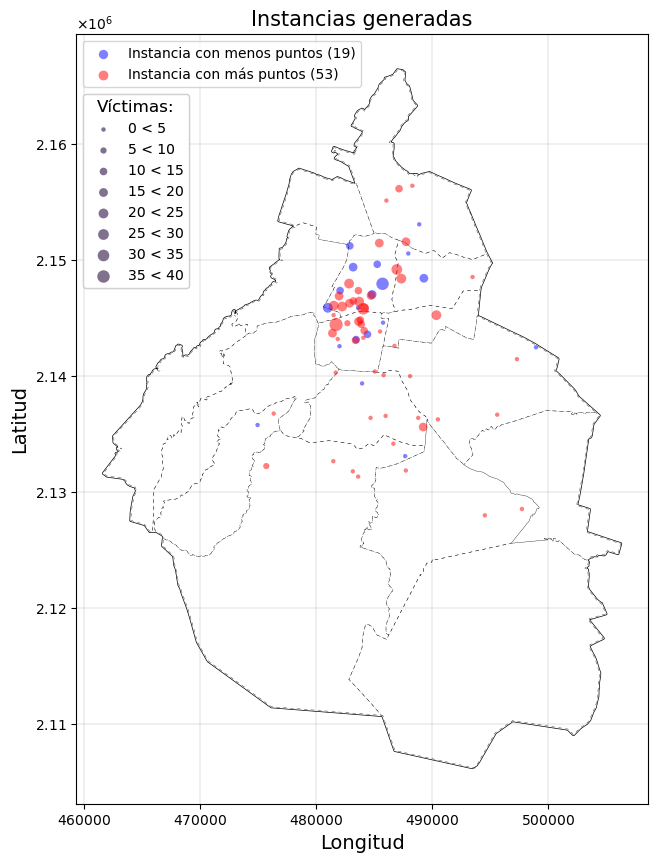

In [14]:

fig2,ax2 = plt.subplots(1,1, figsize=(8,10))

cdmx.plot(ax = ax2, color = 'none', edgecolor = 'black', linewidth = 0.5)
alcaldias.plot(ax = ax2, color = 'none', edgecolor = 'black', linewidth = 0.25, linestyle = (5, (10, 10)))

ins_min = instances[min_instances]
ins_max = instances[max_instances]

f = 10
ins_min['marker_size'] = ins_min['victimas'].apply(lambda x:  ((x + 5)//5)*f)
ins_max['marker_size'] = ins_max['victimas'].apply(lambda x:  ((x + 5)//5)*f)

ins_min.plot(ax = ax2, color = 'b', alpha = 0.5, markersize = ins_min['marker_size'],
                              label = f'Instancia con menos puntos ({min(points_per_instance)})',
                              edgecolor = 'black', linewidth = 0)

ins_max.plot(ax = ax2, color = 'r', alpha = 0.5, markersize = ins_max['marker_size'],
                              label = f'Instancia con más puntos ({max(points_per_instance)})',
                              edgecolor = 'black', linewidth = 0)

ax2.grid(True, color = 'black', alpha = 0.25, linewidth = 0.35, zorder = 0)

ax2.set_xlabel('Longitud', fontsize = 14)
ax2.set_ylabel('Latitud', fontsize = 14)

legend1 = ax2.legend(loc = 'upper left', fontsize = 10)
ax2.set_title('Instancias generadas', fontsize = 15)
# ax2.scatter(instances_points[max_instances][:,0], instances_points[max_instances][:,1], 
#          s = 10, alpha = 0.5, c = 'r')
ax2.add_artist(legend1)



p = []

for m in range(1,9):
    p.append(ax2.scatter([], [], s = m*f, color = (0.1,0,0.2), alpha = 0.5,edgecolor = 'black', linewidth = 0))

legend2 = plt.legend([i for i in p],[f'{(m-1)*5} < {m*5}' for m in range(1,11)], 
                     loc=[0.012,0.67])

legend2.set_title('Víctimas:', prop = {'size': 12})
ax2.add_artist(legend2)
# Añade una leyenda adicional para la combinación de leyendas
#ax2.legend(['Leyenda 1', 'Leyenda 2'], loc='lower right')
fig2.savefig('../Figuras/Results/Instances_minmax.svg')#, dpi = 300, bbox_inches = 'tight')

In [15]:
ins_min['victimas'].sum()

193